# RLCT estimation method - sanity check
---

This notebook is just to implement MCMC based RLCT estimation method using elementary numerical computation libraries for sanity check purpose. 

For this purpose, we will estimate the RLCT for the $d = 2$ model 
$$
 y = a \tanh(b x) + \eta, \quad \eta \sim N(0, \sigma^2)
$$
at different true parameters. We expect 
 - When the truth is regular for the model (when $w_0$ is away from $ab = 0$), we should get $\lambda = d/2 = 1$. 
 - When the truth is singular for the model (when $w_0$ is on $ab = 0$), we should get $\lambda = 1/2$. 


In [23]:
import matplotlib
import matplotlib.pyplot as plt

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random


import numpy as np # should probably use pure jax.numpy instead... using this to handle RNG for now.

# Set up truth and data

In [10]:
@jax.jit
def tanh_reg_func(x, w, h=1):
    num_samples, input_dim = x.shape
    asize = input_dim * h
    a = w[:asize].reshape(input_dim, h)
    b = w[asize:].reshape(h, -1)
    return jnp.matmul(jnp.tanh(jnp.matmul(x, a)), b)

true param: [0.9 0. ]


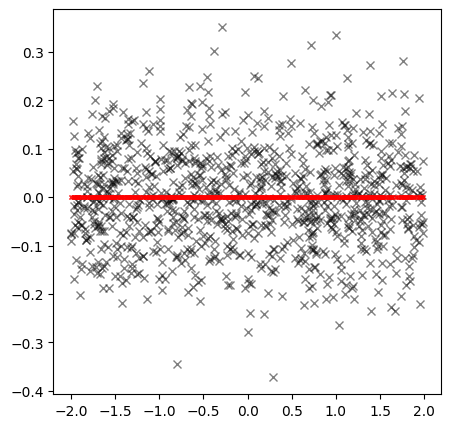

In [18]:
a_0 = jnp.array( # dim = (input_dim, h)
    [[0.9]]
)
b_0 = jnp.array( # dim = (h, output_dim)
    [[0.0]]
)
input_dim, h = a_0.shape
output_dim = b_0.shape[1]

w_0 = jnp.hstack([jnp.ravel(a_0), jnp.ravel(b_0)])
print(f"true param: {w_0}")

rng_key, noise_key = random.split(random.PRNGKey(42))
num_training_samples = 1032

xmin, xmax = -2.0, 2.0
X = (xmax - xmin) * random.uniform(rng_key, shape=(num_training_samples, input_dim)) + xmin
Y = tanh_reg_func(X, w_0) + random.normal(noise_key, (num_training_samples, output_dim)) * 0.1

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X, Y, "kx", alpha=0.5)
ax.plot(X, tanh_reg_func(X, w_0), "rx", markersize=3, alpha=0.5);

# Set up model

In [19]:
@jax.jit
def nll(X, Y, w, sigma=0.1):
    yhat = tanh_reg_func(X, w)
    return 1 / (2 * sigma**2) * jnp.sum(jnp.square(Y - yhat))

@jax.jit
def log_prior(w, sigma=1.0):
    return -1/ (2 * sigma**2) * jnp.sum(w**2)

@jax.jit
def log_prob(X, Y, w, sigma=0.1, itemp=1.0):
    return -itemp * nll(X, Y, w, sigma=sigma) + log_prior(w)


def proposal_distribution(x, step_size):
    return np.random.normal(x, step_size)

def target_distribution(w, itemp=1.0):
    return np.exp(log_prob(X, Y, w, sigma=0.1, itemp=itemp))

def rand_init(shape):
    return np.random.randn(*shape) * 1.0

def metropolis_hastings(
    num_samples, 
    step_size, 
    sample_shape, 
    itemp=1.0, 
    initial_state=None, 
    num_chains=1, 
    verbose=False
):

    samples = np.zeros([num_samples * num_chains] + list(sample_shape))
    
    for c in range(num_chains):
        acceptance_counter = 0
        if initial_state is None:
            init = rand_init(sample_shape)
        else:
            init = initial_state
        state = init
        for i in range(num_samples):
            proposed_state = proposal_distribution(state, step_size)
            acceptance_ratio = log_prob
            acceptance_ratio = (
                target_distribution(proposed_state, itemp) /
                target_distribution(state, itemp)
            )
            if np.random.uniform(0, 1) < acceptance_ratio:
                state = proposed_state
                acceptance_counter += 1

            samples[c * num_samples + i] = state
        if verbose:
            print(f"Chain: {c}, acceptance rate: {acceptance_counter / num_samples:.3f}")
    
    return samples

# Running MCMC to visualise the posterior

Observations: 
 - Step size of MH-MCMC needs to be carefully tuned depending on how concentrated the posterior is, which depends on `num_training_samples` and the temperature. High `n`, low temperature => need small step size and vice versa. 
 - When posterior is very concentrated (high `n` low temp), random MCMC initialisation will fail as it will be stuck waiting for a random jump towards a high probability region. In this case, starting near the true parameter works but isn't ideal as it won't explore other modes with small step sizes. 


Chain: 0, acceptance rate: 0.957
Chain: 1, acceptance rate: 0.912
Chain: 2, acceptance rate: 0.966
Chain: 3, acceptance rate: 0.961
Chain: 4, acceptance rate: 0.978
0.2841638 0.45497397


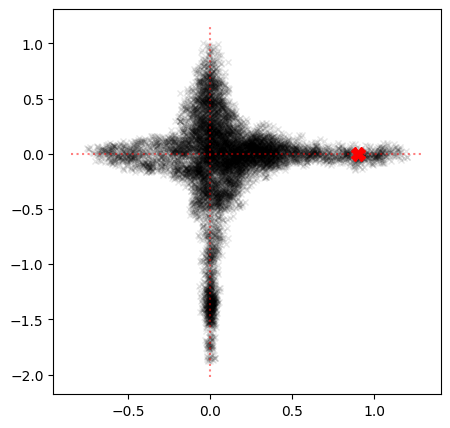

In [26]:
num_mcmc_step = 20000
num_chains = 5
thin = 10
# init_state = w_0
# init_state = None # random initialisation 
init_state = jnp.zeros_like(w_0)
mcmc_step_size = 0.01 

s = metropolis_hastings(
    num_mcmc_step, 
    mcmc_step_size, 
    sample_shape=tuple(w_0.shape), 
    itemp=0.01, 
    initial_state=init_state,
    num_chains=num_chains, 
    verbose=True
)

fig, ax = plt.subplots(figsize=(5, 5))
a_samples = s[::thin, 0]
b_samples = s[::thin, 1]
ax.plot(a_samples, b_samples, "kx", markersize=5, alpha=0.1)
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
ax.plot([w_0[0]], [w_0[1]], "rX", markersize=10)

print(jnp.std(a_samples), jnp.std(b_samples))

# Running MCMC for posterior at different temperatures 

In [22]:
n = num_training_samples
num_itemps = 10
itemps = np.linspace(
    1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
    1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), 
    num_itemps
)
# itemps = np.array(list(itemps) + [1.0, 1.5, 1.7, 2.0])

num_mcmc_step = 20000
init_state = w_0
mcmc_step_size = 0.05
thin = 20
num_chains = 5

enlls = []
for itemp in itemps:
    if itemp < 1: 
        mcmc_step_size = 0.01
    else:
        mcmc_step_size = 0.0001
        
    s = metropolis_hastings(
        num_mcmc_step, 
        mcmc_step_size, 
        sample_shape=tuple(w_0.shape), 
        itemp=itemp, 
#         initial_state=jnp.zeros_like(w_0),
#         initial_state=None,
        initial_state=w_0,
        num_chains=num_chains, 
        verbose=True
    )
    enll = np.mean([nll(X, Y, w_sample, sigma=0.1) for w_sample in s[::thin]])
    print(itemp, enll)
    enlls.append(enll)
    

Chain: 0, acceptance rate: 0.890
Chain: 1, acceptance rate: 0.781
Chain: 2, acceptance rate: 0.828
Chain: 3, acceptance rate: 0.852
Chain: 4, acceptance rate: 0.845
0.10542509521128493 535.2645
Chain: 0, acceptance rate: 0.743
Chain: 1, acceptance rate: 0.915
Chain: 2, acceptance rate: 0.920
Chain: 3, acceptance rate: 0.921
Chain: 4, acceptance rate: 0.815
0.11402123198239238 534.681
Chain: 0, acceptance rate: 0.852
Chain: 1, acceptance rate: 0.748
Chain: 2, acceptance rate: 0.907
Chain: 3, acceptance rate: 0.797
Chain: 4, acceptance rate: 0.772
0.12261736875349982 534.792
Chain: 0, acceptance rate: 0.847
Chain: 1, acceptance rate: 0.740
Chain: 2, acceptance rate: 0.726
Chain: 3, acceptance rate: 0.857
Chain: 4, acceptance rate: 0.817
0.13121350552460725 534.25214
Chain: 0, acceptance rate: 0.903
Chain: 1, acceptance rate: 0.792
Chain: 2, acceptance rate: 0.852
Chain: 3, acceptance rate: 0.840
Chain: 4, acceptance rate: 0.866
0.13980964229571471 533.9048
Chain: 0, acceptance rate: 0.85

R^2=0.9360117062212866


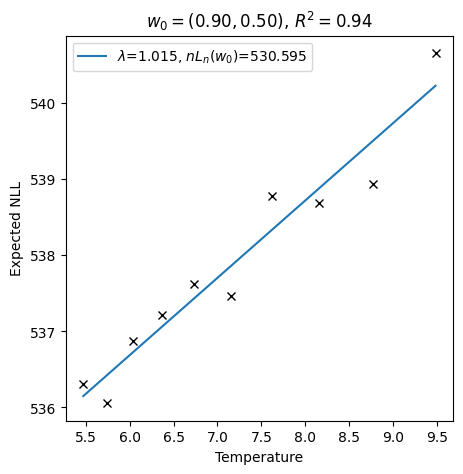

In [129]:
import scipy

fig, ax = plt.subplots(figsize=(5,5))


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
ax.plot(1/itemps, enlls, "kx")
ax.plot(1/itemps, 1/itemps * slope + intercept, label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}")
print(f"R^2={r_val**2}")


# slope, intercept, r_val, p_val, _ = scipy.stats.linregress(1 / itemps[:num_itemps], enlls[:num_itemps])
# ax.plot(1/itemps[:num_itemps], enlls[:num_itemps], "kx")
# ax.plot(
#     1/itemps[:num_itemps], 
#     1/itemps[:num_itemps] * slope + intercept, 
#     label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
# )
# print(f"R^2={r_val**2}, p_val={p_val}")


# slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[num_itemps:], enlls[num_itemps:])
# ax.plot(1/itemps[num_itemps:], enlls[num_itemps:], "kx")
# ax.plot(
#     1/itemps[num_itemps:], 
#     1/itemps[num_itemps:] * slope + intercept, 
#     label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
# )
# print(f"R^2={r_val**2}")

ax.legend()

ax.set_title(f"$w_0 = ({w_0[0]:.2f}, {w_0[1]:.2f})$, $R^2={r_val**2:.2f}$")
ax.set_xlabel("Temperature")
ax.set_ylabel("Expected NLL");